#CNN model Experiments
In this notebook, CNN model will be experimented with different learning rates and batch size combinations.

The whole notebook will be divided into 5 parts.

- **Part 1:** **Dataset** - Dataset will be loaded and preprocessed in this part.
- **Part 2:** **Define functions** - Create model function, Training function, Accuracy and loss curve function and evaluate function will be defined here.
- **Part 3:** **Hyperparameter tuning**
  - 3.1 Learning Rate (LR) Experiments
  - 3.2 Batch Size Experiments
- **Part 4: Train Best model for more epochs**
- **Part 5: Train best model on oversampled dataset**

#Mount Google Drive and import libraries

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models

Mounted at /content/drive


In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import random

# Set the seed
random.seed(42)

#Part 1: Dataset

##Load training data

In [ ]:
# Define paths to dataset
train_dir = '/content/drive/My Drive/Data/GTSRB/Train/GTSRB/Final_Training/Images/'
test_dir = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/'

# Define image size
IMG_SIZE = 32  # Resize images
num_classes = 43

# Define function to load images and labels
def load_data(data_dir):
    images = []
    labels = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    # Loop through each subdirectory (which corresponds to a class)
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)

        if os.path.isdir(label_path):
            label = int(label_dir)  # Subdirectory name is the class label

            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)

                # Check if the file has a valid image extension
                _, file_extension = os.path.splitext(img_file)
                if file_extension.lower() not in valid_extensions:
                    print(f"Skipping non-image file: {img_file}")
                    continue  # Skip non-image files (e.g., CSV)

                # Read the image using OpenCV
                image = cv2.imread(img_path)

                # Resize image
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

                # Append the image and label to the lists
                images.append(image)
                labels.append(label)

    # Convert to NumPy arrays and normalize
    images = np.array(images, dtype='float32') / 255.0  # Normalize images
    labels = to_categorical(labels, num_classes)  # One-hot encode labels

    return images, labels

# Load training data
images, labels = load_data(train_dir)

Skipping non-image file: GT-00000.csv
Skipping non-image file: GT-00001.csv
Skipping non-image file: GT-00002.csv
Skipping non-image file: GT-00003.csv
Skipping non-image file: GT-00004.csv
Skipping non-image file: GT-00005.csv
Skipping non-image file: GT-00006.csv
Skipping non-image file: GT-00007.csv
Skipping non-image file: GT-00008.csv
Skipping non-image file: GT-00009.csv
Skipping non-image file: GT-00010.csv
Skipping non-image file: GT-00011.csv
Skipping non-image file: GT-00012.csv
Skipping non-image file: GT-00013.csv
Skipping non-image file: GT-00014.csv
Skipping non-image file: GT-00015.csv
Skipping non-image file: GT-00016.csv
Skipping non-image file: GT-00017.csv
Skipping non-image file: GT-00018.csv
Skipping non-image file: GT-00019.csv
Skipping non-image file: GT-00020.csv
Skipping non-image file: GT-00021.csv
Skipping non-image file: GT-00022.csv
Skipping non-image file: GT-00023.csv
Skipping non-image file: GT-00024.csv
Skipping non-image file: GT-00025.csv
Skipping non

## Print total number of images in the training dataset

In [ ]:
# Store the images and labels in two new folders
train_images, train_labels = images, labels

# Print dataset shape
print(f'train_images shape: {train_images.shape}')
print(f'train_labels shape: {train_labels.shape}')

train_images shape: (39209, 32, 32, 3)
train_labels shape: (39209, 43)


##Split dataset into training and validation set
Here, the dataset will be splited into training and validation sets, where 80% of the dataset will be used for training, and the remaining 20% for validation. This keeps a validation set for observing model performance and preventing overfitting while making sure a sufficient training set for model training.

In [ ]:
train_images, train_labels = images, labels

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Training data shape: (31367, 32, 32, 3)
Validation data shape: (7842, 32, 32, 3)


## Load test data

In [ ]:
# Write a function to load the test data
def load_test_data(test_dir):
    images = []
    img_names = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)

        # Check if the file is an image
        _, file_extension = os.path.splitext(img_file)
        if file_extension.lower() not in valid_extensions:
            print(f"Skipping non-image file: {img_file}")
            continue  # Skip non-image files

        # Read and resize the image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        # Append the image and image file name to the lists
        images.append(image)
        img_names.append(img_file)

    # Convert images to a NumPy array
    images = np.array(images, dtype='float32') / 255.0  # Normalize images

    return images, img_names

# Load test images
X_test, test_img_names = load_test_data(test_dir)

Skipping non-image file: GT-final_test.test.csv


##Total Number of images in the test data

In [ ]:
# Print test dataset shape
print(f'X_test shape: {X_test.shape}')

X_test shape: (12630, 32, 32, 3)


#Part 2: Define Functions

##Create Model Function


In [ ]:
# Define a function to create model
def create_cnn_model(input_shape):

  """
  This function will create a CNN model.
  It will accept input shape as a parameter.
  """

  # Build a simple CNN model
  model = models.Sequential()

  # Convolutional layer
  model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
  model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.BatchNormalization(axis=-1))

  # Add more layers
  model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
  model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.BatchNormalization(axis=-1))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(rate=0.5))

  model.add(layers.Dense(num_classes, activation='softmax'))

  return model

# call create model function
model = create_cnn_model((IMG_SIZE,IMG_SIZE, 3))

# print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 5, 5, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,638,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,761,099 (6.72 MB)

 Trainable params: 1,759,755 (6.71 MB)

 Non-trainable params: 1,344 (5.25 KB)

##Compile and train model Function

In [ ]:
# define a function to train the model
def train_model(model, lr, BATCH_SIZE, EPOCHS):
    """
    This function will train the model.
    Parameters:
        model: the model that will be trained
        lr: learning rate
        BATCH_SIZE: batch size
        EPOCHS: number of epochs
    """
    # Initialize EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        callbacks=[early_stopping]
    )

    return history

##Accuracy and loss curve Function

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# write a function to visualize curves
def visualize_training_curves(history):

    """
    This function will plot the accuracy and loss curve of the trained model.
    parameter:
        history: It contains taining history of the model
    """

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # set epochs to start from 1
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot accuracy
    axes[0].plot(epochs, history.history['accuracy'], label='train_accuracy', color="blue")
    axes[0].plot(epochs, history.history['val_accuracy'], label='val_accuracy', color="orange")
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylim(0, 1)
    axes[0].legend(loc='lower right')
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis ticks as integers because epochs can't be float

    # Plot loss
    axes[1].plot(epochs, history.history['loss'], label='train_loss', color="green")
    axes[1].plot(epochs, history.history['val_loss'], label='val_loss', color="red")
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis ticks as integers because epochs can't be float

    plt.tight_layout()
    plt.show()

##Evaluate model on test data Function

In [ ]:
# Write a function to evaluate the trained model
def evaluate_model(model, X_test, ground_truth_df):

    """
    This function will evaluate the trained model on test data.
    Parameters:
        model: The trained model
        X_test: contains the test dataset
        ground_truth: contains the true class of the test images
    """

    # Predict class probabilities
    predictions = model.predict(X_test)

    # Get the class index with the highest probability
    predicted_classes = np.argmax(predictions, axis=1)

    # Save predicted classes and the image file names to a dataframe
    predictions_df = pd.DataFrame({
        'Filename': test_img_names,
        'Predicted Class': predicted_classes
    })

    # Ensure the filenames are sorted in ascending order in the result file
    predictions_df = predictions_df.sort_values(by='Filename')

    # Merge both dataframes on the 'Filename' column
    merged_df = pd.merge(predictions_df, ground_truth_df[['Filename', 'ClassId']], on='Filename')

    # Calculate accuracy by comparing predicted classes with actual classes
    accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

    print(f"Learning rate: {lr},\nBatch Size: {BATCH_SIZE},")

    # get the lowest validation loss epoch
    epoch_with_lowest_val_loss = np.argmin(history.history['val_loss'])

    # get validation accuracy of that epoch
    val_accuracy = history.history['val_accuracy'][epoch_with_lowest_val_loss]

    # print validation accuracy and test accuracy
    print(f"Validation accuracy: {val_accuracy*100:.2f}%,\nTest Accuracy: {accuracy * 100:.2f}%.")

#Part 3: Hyperparameter Tuning
In the following cell, different learning rates and batch sizes will be experimented on the model. The batch size will be set to 32 during learning rate experiments. During experiments model will be trained for 5 epochs only. Then the best models will be trained for more epochs.

##3.1 Learning Rate (LR) Experiments

###Compile and train the model


Training model with learning rate = 0.1 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.1434 - loss: 8.0142 - val_accuracy: 0.0366 - val_loss: 280.2883
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.2441 - loss: 8.9559 - val_accuracy: 0.5307 - val_loss: 69.3709
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5582 - loss: 6.9006 - val_accuracy: 0.8211 - val_loss: 224575.5312
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7770 - loss: 9.2212 - val_accuracy: 0.8520 - val_loss: 66912.1172
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8658 - loss: 8.5760 - val_accuracy: 0.9411 - val_loss: 699.1982


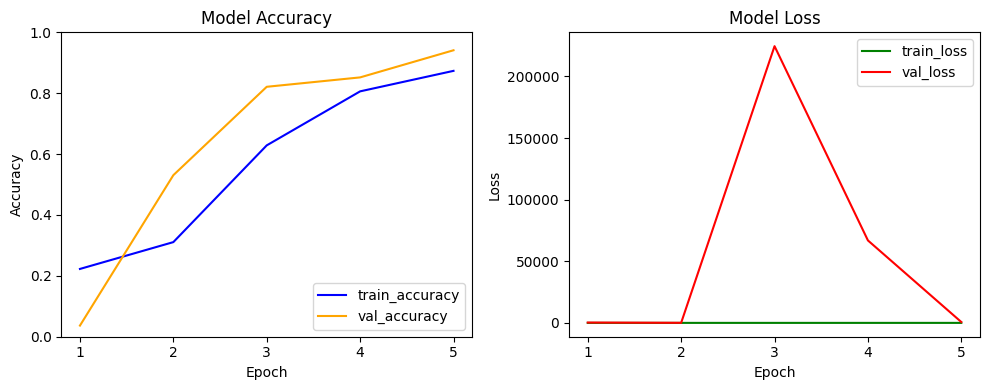

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Learning rate: 0.1,
Batch Size: 32,
Validation accuracy: 53.07%,
Test Accuracy: 51.01%.

Training model with learning rate = 0.01 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.7157 - loss: 1.2744 - val_accuracy: 0.9282 - val_loss: 0.2214
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9244 - loss: 0.2851 - val_accuracy: 0.9730 - val_loss: 0.1112
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9694 - loss: 0.1157 - val_accuracy: 0.9830 - val_loss: 0.0601
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9659 - loss: 0.1401 - val_accuracy: 0.9676 - val_loss: 0.2196
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9790 - loss: 0.1033 - val_accuracy: 0.9703 - val_loss: 0.1631


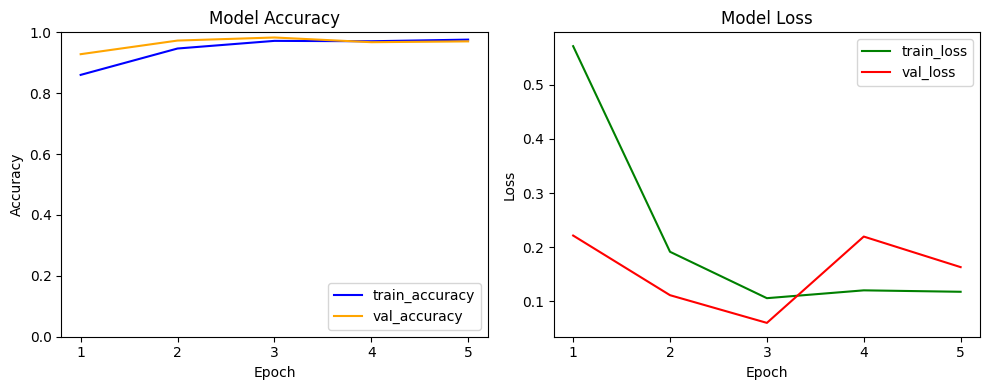

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.01,
Batch Size: 32,
Validation accuracy: 98.30%,
Test Accuracy: 94.15%.

Training model with learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.7511 - loss: 1.0092 - val_accuracy: 0.9872 - val_loss: 0.0476
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9864 - loss: 0.0447 - val_accuracy: 0.9883 - val_loss: 0.0395
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9940 - loss: 0.0211 - val_accuracy: 0.9832 - val_loss: 0.0541
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9914 - loss: 0.0276 - val_accuracy: 0.9726 - val_loss: 0.1071
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9959 - loss: 0.0165 - val_accuracy: 0.9843 - val_loss: 0.0533


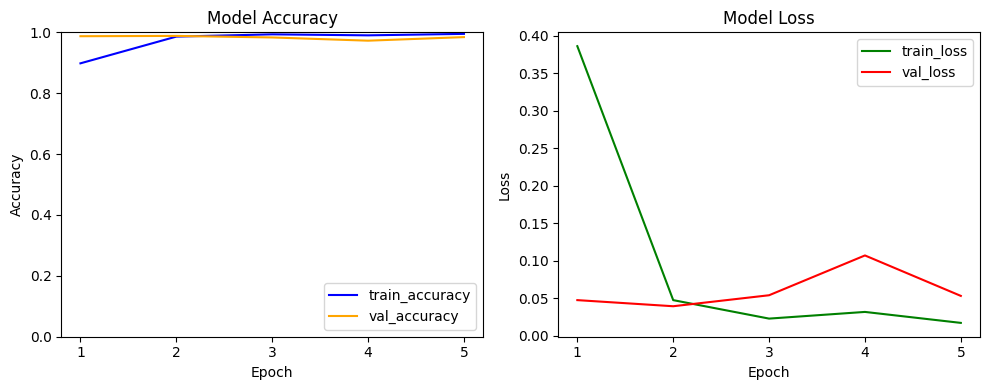

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.83%,
Test Accuracy: 95.72%.

Training model with learning rate = 0.0001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.5179 - loss: 1.9888 - val_accuracy: 0.9540 - val_loss: 0.1916
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9419 - loss: 0.2170 - val_accuracy: 0.9862 - val_loss: 0.0692
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9802 - loss: 0.0801 - val_accuracy: 0.9895 - val_loss: 0.0434
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9910 - loss: 0.0408 - val_accuracy: 0.9916 - val_loss: 0.0351
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9955 - loss: 0.0247 - val_accuracy: 0.9936 - val_loss: 0.0290


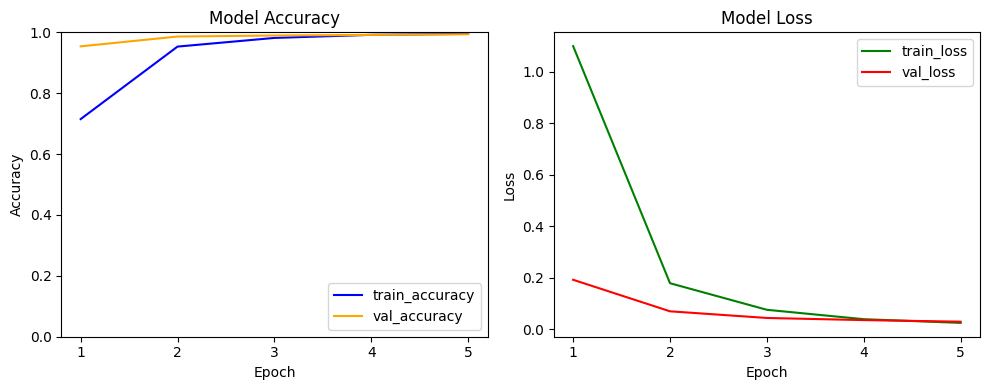

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Learning rate: 0.0001,
Batch Size: 32,
Validation accuracy: 99.36%,
Test Accuracy: 95.14%.

Training model with learning rate = 1e-05 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.1537 - loss: 3.9104 - val_accuracy: 0.6004 - val_loss: 1.5364
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5033 - loss: 1.8587 - val_accuracy: 0.7673 - val_loss: 0.9206
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6618 - loss: 1.1967 - val_accuracy: 0.8511 - val_loss: 0.6161
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7616 - loss: 0.8482 - val_accuracy: 0.8998 - val_loss: 0.4322
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8259 - loss: 0.6084 - val_accuracy: 0.9332 - val_loss: 0.3154


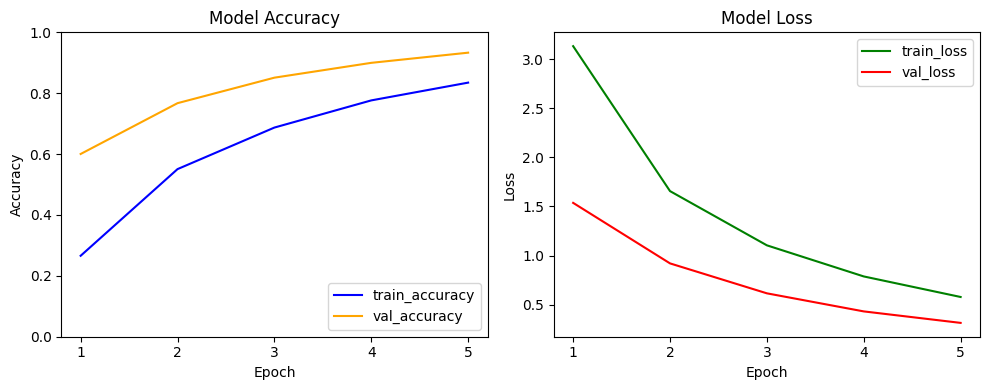

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Learning rate: 1e-05,
Batch Size: 32,
Validation accuracy: 93.32%,
Test Accuracy: 82.11%.

Training model with learning rate = 1e-06 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.0329 - loss: 5.1288 - val_accuracy: 0.1196 - val_loss: 3.6676
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0840 - loss: 4.3086 - val_accuracy: 0.2270 - val_loss: 3.1250
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1414 - loss: 3.8125 - val_accuracy: 0.3105 - val_loss: 2.7504
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2005 - loss: 3.4309 - val_accuracy: 0.3721 - val_loss: 2.4714
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2508 - loss: 3.1386 - val_accuracy: 0.4226 - val_loss: 2.2504


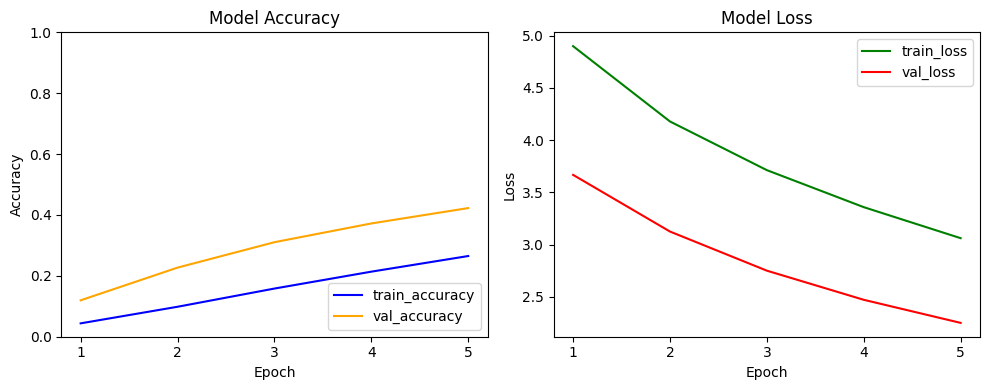

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 1e-06,
Batch Size: 32,
Validation accuracy: 42.26%,
Test Accuracy: 36.94%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# load the ground truth file (downloaded separately)
ground_truth = pd.read_csv('/content/drive/My Drive/Data/GTSRB/GT-final_test.csv', sep=';')

learning_rate = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
BATCH_SIZE = 32
EPOCHS = 5

for lr in learning_rate:

    print(f"\nTraining model with learning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = create_cnn_model((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

##Results:
Learning rate: 0.1,
Batch Size: 32,
Validation accuracy: 53.07%,
Test Accuracy: 51.01%.

Learning rate: 0.01,
Batch Size: 32,
Validation accuracy: 98.30%,
Test Accuracy: **94.15%**.

Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.83%,
Test Accuracy: **95.72%**.

Learning rate: 0.0001,
Batch Size: 32,
Validation accuracy: 99.36%,
Test Accuracy: **95.14%**.

Learning rate: 1e-05,
Batch Size: 32,
Validation accuracy: 93.32%,
Test Accuracy: 82.11%.

Learning rate: 1e-06,
Batch Size: 32,
Validation accuracy: 42.26%,
Test Accuracy: 36.94%.

**For the best 3 models, batch size will be experimented in the next step.**

##3.2 Batch Size Experiments

Different batch sizes will be experimented on the best models in the following cells with different learning rates.

###Compile and train the model


Training model with learning rate = 0.01 and Batch Size = 16
Epoch 1/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.3789 - loss: 2.8040 - val_accuracy: 0.7898 - val_loss: 0.8641
Epoch 2/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8704 - loss: 0.4311 - val_accuracy: 0.9509 - val_loss: 0.1760
Epoch 3/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9287 - loss: 0.2594 - val_accuracy: 0.9572 - val_loss: 0.1601
Epoch 4/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9391 - loss: 0.2620 - val_accuracy: 0.9783 - val_loss: 0.1052
Epoch 5/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9452 - loss: 0.2625 - val_accuracy: 0.9716 - val_loss: 0.1541


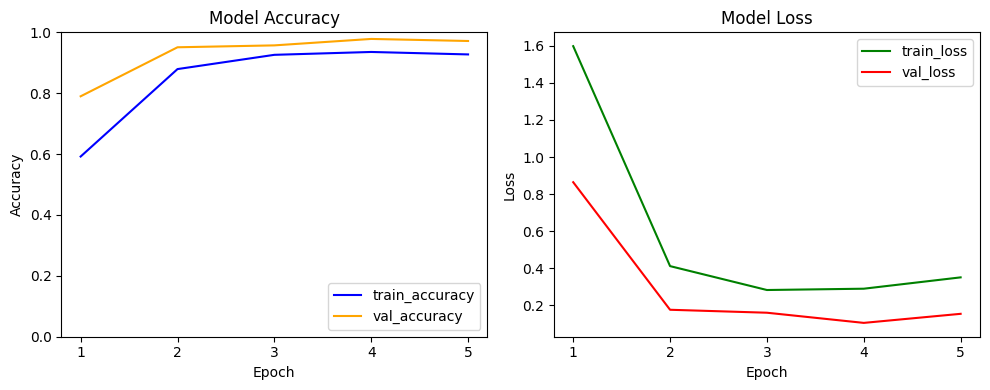

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.01,
Batch Size: 16,
Validation accuracy: 97.83%,
Test Accuracy: 95.11%.

Training model with learning rate = 0.01 and Batch Size = 64
Epoch 1/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.6133 - loss: 1.6707 - val_accuracy: 0.9662 - val_loss: 0.1252
Epoch 2/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9645 - loss: 0.1251 - val_accuracy: 0.9625 - val_loss: 0.1433
Epoch 3/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9778 - loss: 0.0805 - val_accuracy: 0.9768 - val_loss: 0.0802
Epoch 4/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9820 - loss: 0.0625 - val_accuracy: 0.9819 - val_loss: 0.0674
Epoch 5/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9842 - loss: 0.0604 - val_accuracy: 0.9677 - val_loss: 0.1260


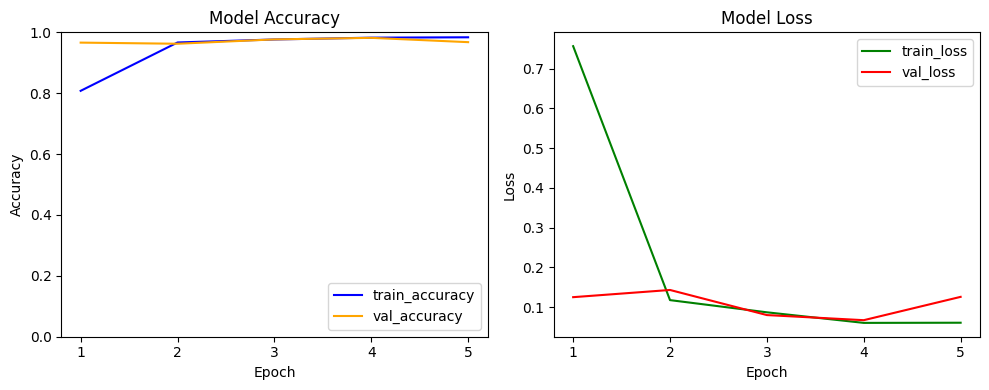

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.01,
Batch Size: 64,
Validation accuracy: 98.19%,
Test Accuracy: 94.64%.

Training model with learning rate = 0.01 and Batch Size = 128
Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.6629 - loss: 1.4631 - val_accuracy: 0.7042 - val_loss: 0.9823
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.9723 - loss: 0.0962 - val_accuracy: 0.9763 - val_loss: 0.0792
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9877 - loss: 0.0385 - val_accuracy: 0.9728 - val_loss: 0.1083
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9822 - loss: 0.0618 - val_accuracy: 0.9833 - val_loss: 0.0608
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9843 - loss: 0.0539 - val_accuracy: 0.9718 - val_loss: 0.0985


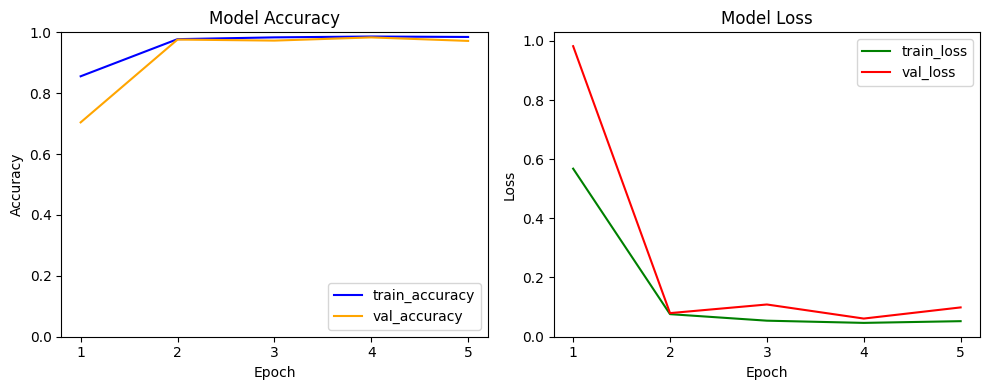

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.01,
Batch Size: 128,
Validation accuracy: 98.33%,
Test Accuracy: 95.33%.

Training model with learning rate = 0.01 and Batch Size = 256
Epoch 1/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.5816 - loss: 1.7669 - val_accuracy: 0.1237 - val_loss: 5.9503
Epoch 2/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1237 - val_loss: 5.9503
Epoch 3/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9770 - loss: 0.0743 - val_accuracy: 0.6973 - val_loss: 1.2041
Epoch 4/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6973 - val_loss: 1.2041
Epoch 5/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9897 - loss: 0.0342 - val_accuracy: 0.9716 - val_loss: 0.0979


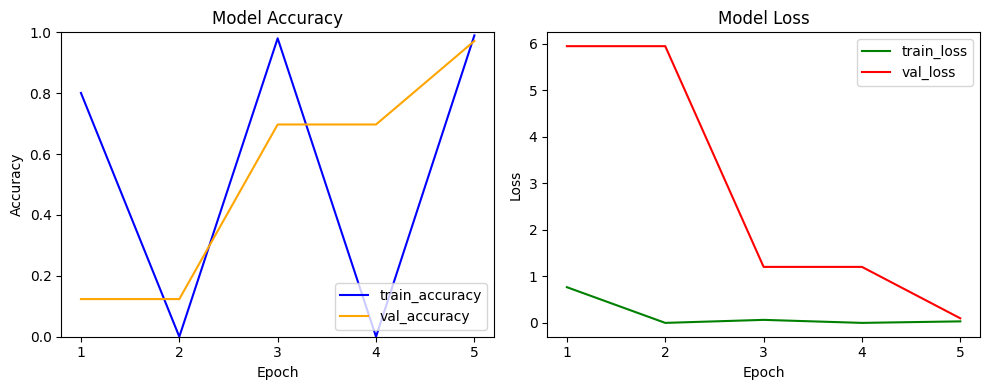

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Learning rate: 0.01,
Batch Size: 256,
Validation accuracy: 97.16%,
Test Accuracy: 92.06%.

Training model with learning rate = 0.001 and Batch Size = 16
Epoch 1/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.7440 - loss: 1.0442 - val_accuracy: 0.9799 - val_loss: 0.0688
Epoch 2/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9818 - loss: 0.0609 - val_accuracy: 0.9903 - val_loss: 0.0347
Epoch 3/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9748 - loss: 0.0865 - val_accuracy: 0.9843 - val_loss: 0.0547
Epoch 4/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9808 - loss: 0.0664 - val_accuracy: 0.9904 - val_loss: 0.0334
Epoch 5/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9897 - loss: 0.0313 - val_accuracy: 0.9938 - val_loss: 0.0238


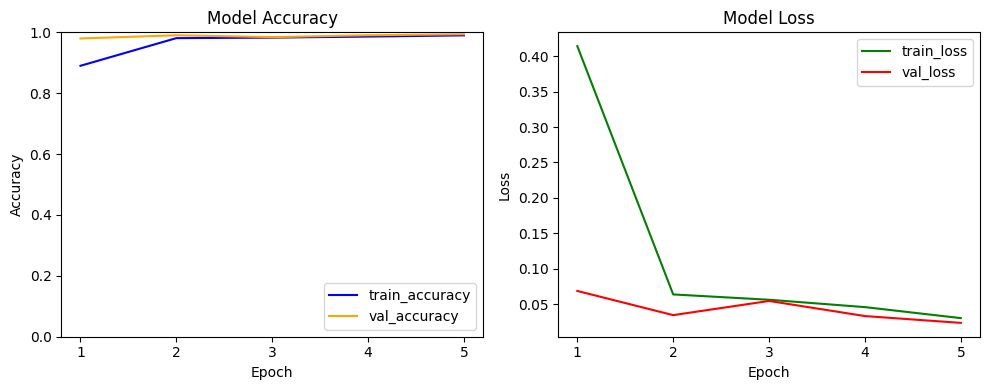

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Learning rate: 0.001,
Batch Size: 16,
Validation accuracy: 99.38%,
Test Accuracy: 97.13%.

Training model with learning rate = 0.001 and Batch Size = 64
Epoch 1/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7620 - loss: 0.9766 - val_accuracy: 0.8378 - val_loss: 0.6020
Epoch 2/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9892 - loss: 0.0365 - val_accuracy: 0.9865 - val_loss: 0.0477
Epoch 3/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9942 - loss: 0.0194 - val_accuracy: 0.9883 - val_loss: 0.0438
Epoch 4/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9955 - loss: 0.0152 - val_accuracy: 0.9932 - val_loss: 0.0245
Epoch 5/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9973 - loss: 0.0112 - val_accuracy: 0.9906 - val_loss: 0.0481


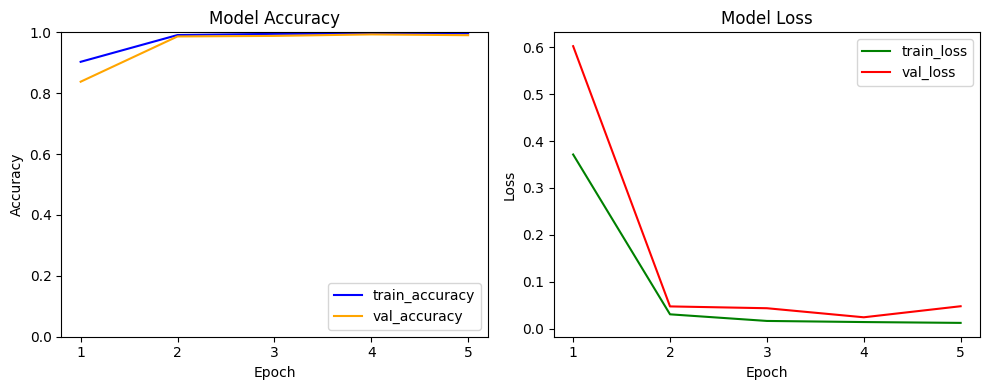

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.001,
Batch Size: 64,
Validation accuracy: 99.32%,
Test Accuracy: 96.22%.

Training model with learning rate = 0.001 and Batch Size = 128
Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.6856 - loss: 1.3096 - val_accuracy: 0.1642 - val_loss: 3.5027
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9912 - loss: 0.0367 - val_accuracy: 0.5420 - val_loss: 1.4188
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9963 - loss: 0.0147 - val_accuracy: 0.9929 - val_loss: 0.0269
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9986 - loss: 0.0067 - val_accuracy: 0.9964 - val_loss: 0.0146
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9988 - loss: 0.0050 - val_accuracy: 0.9958 - val_loss: 0.0165


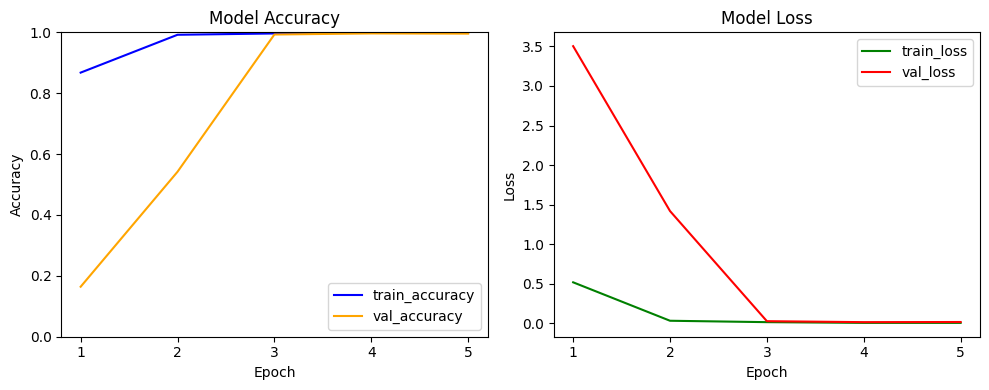

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.64%,
Test Accuracy: 97.44%.

Training model with learning rate = 0.001 and Batch Size = 256
Epoch 1/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.6509 - loss: 1.4540 - val_accuracy: 0.0652 - val_loss: 4.0432
Epoch 2/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0652 - val_loss: 4.0432
Epoch 3/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9893 - loss: 0.0466 - val_accuracy: 0.0598 - val_loss: 4.6225
Epoch 4/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0598 - val_loss: 4.6225
Epoch 5/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9972 - loss: 0.0144 - val_accuracy: 0.1765 - val_loss: 3.5475


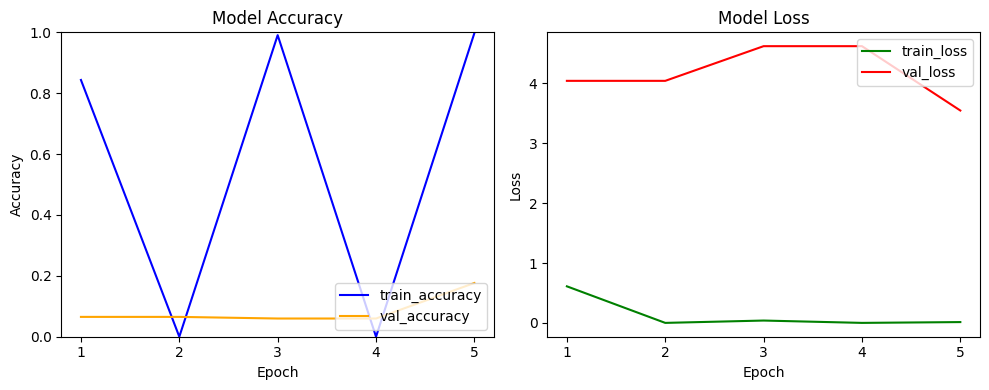

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Learning rate: 0.001,
Batch Size: 256,
Validation accuracy: 17.65%,
Test Accuracy: 16.84%.

Training model with learning rate = 0.0001 and Batch Size = 16
Epoch 1/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.5671 - loss: 1.7937 - val_accuracy: 0.9711 - val_loss: 0.1266
Epoch 2/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9496 - loss: 0.1778 - val_accuracy: 0.9865 - val_loss: 0.0506
Epoch 3/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9823 - loss: 0.0708 - val_accuracy: 0.9925 - val_loss: 0.0278
Epoch 4/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9912 - loss: 0.0368 - val_accuracy: 0.9931 - val_loss: 0.0252
Epoch 5/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9932 - loss: 0.0250 - val_accuracy: 0.9944 - val_loss: 0.0187


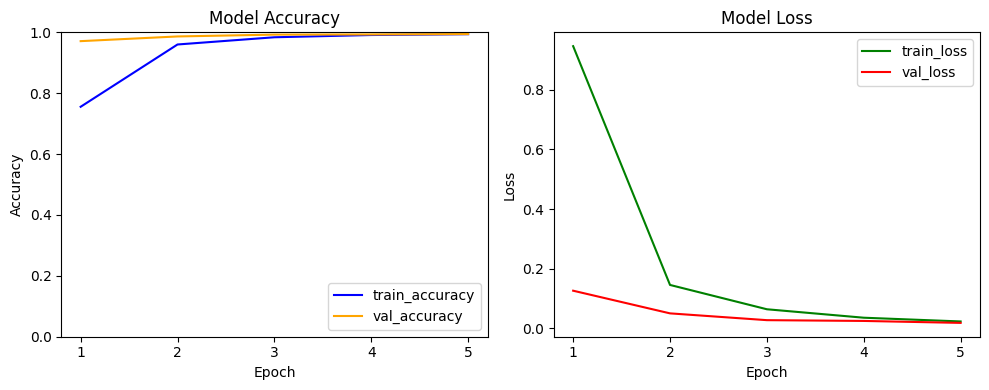

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Learning rate: 0.0001,
Batch Size: 16,
Validation accuracy: 99.44%,
Test Accuracy: 96.29%.

Training model with learning rate = 0.0001 and Batch Size = 64
Epoch 1/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.4592 - loss: 2.2943 - val_accuracy: 0.7717 - val_loss: 0.9334
Epoch 2/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9245 - loss: 0.2818 - val_accuracy: 0.9782 - val_loss: 0.0989
Epoch 3/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9743 - loss: 0.1098 - val_accuracy: 0.9898 - val_loss: 0.0540
Epoch 4/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9850 - loss: 0.0646 - val_accuracy: 0.9913 - val_loss: 0.0405
Epoch 5/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9928 - loss: 0.0367 - val_accuracy: 0.9925 - val_loss: 0.0339


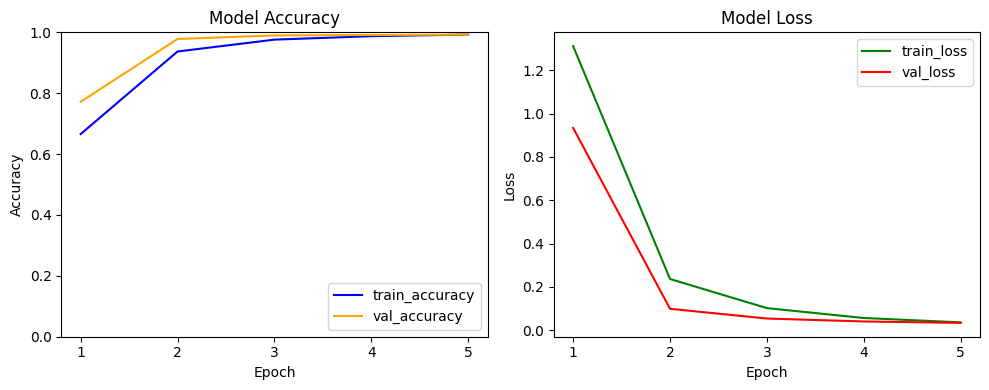

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.0001,
Batch Size: 64,
Validation accuracy: 99.25%,
Test Accuracy: 94.60%.

Training model with learning rate = 0.0001 and Batch Size = 128
Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 30s 104ms/step - accuracy: 0.4044 - loss: 2.5355 - val_accuracy: 0.2104 - val_loss: 3.1339
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8915 - loss: 0.4093 - val_accuracy: 0.7772 - val_loss: 0.8234
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9591 - loss: 0.1664 - val_accuracy: 0.9795 - val_loss: 0.1027
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9813 - loss: 0.0879 - val_accuracy: 0.9878 - val_loss: 0.0589
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9889 - loss: 0.0576 - val_accuracy: 0.9916 - val_loss: 0.0422


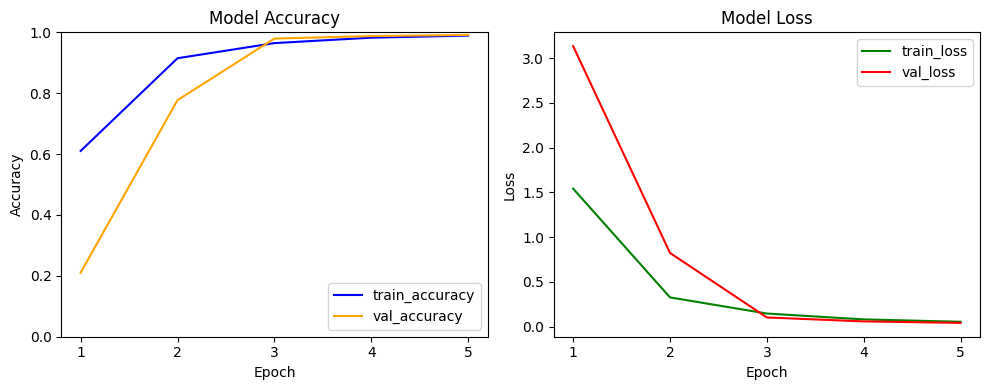

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.0001,
Batch Size: 128,
Validation accuracy: 99.16%,
Test Accuracy: 93.42%.

Training model with learning rate = 0.0001 and Batch Size = 256
Epoch 1/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.3266 - loss: 2.9583 - val_accuracy: 0.1191 - val_loss: 3.5435
Epoch 2/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1191 - val_loss: 3.5435
Epoch 3/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8413 - loss: 0.5896 - val_accuracy: 0.3170 - val_loss: 2.8941
Epoch 4/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3170 - val_loss: 2.8941
Epoch 5/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9359 - loss: 0.2509 - val_accuracy: 0.5655 - val_loss: 1.6507


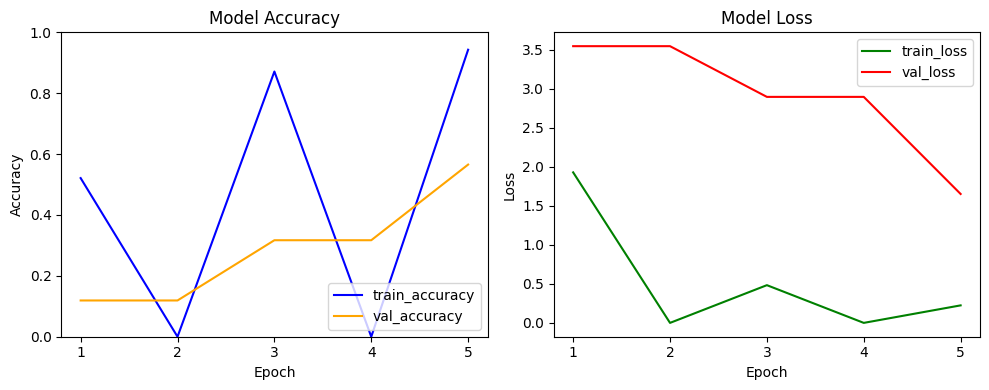

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Learning rate: 0.0001,
Batch Size: 256,
Validation accuracy: 56.55%,
Test Accuracy: 51.77%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = [0.01, 0.001, 0.0001]
batch_sizes = [16, 64, 128, 256]
EPOCHS = 5

for lr in learning_rate:
  for BATCH_SIZE in batch_sizes:

    print(f"\nTraining model with learning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = create_cnn_model((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

##Results:
Learning rate: 0.01,
Batch Size: 16,
Validation accuracy: 97.83%,
Test Accuracy: 95.11%.

Learning rate: 0.01,
Batch Size: 32,
Validation accuracy: 98.30%,
Test Accuracy: 94.15%.

Learning rate: 0.01,
Batch Size: 64,
Validation accuracy: 98.19%,
Test Accuracy: 94.64%.

Learning rate: 0.01,
Batch Size: 128,
Validation accuracy: 98.33%,
Test Accuracy: 95.33%.

Learning rate: 0.01,
Batch Size: 256,
Validation accuracy: 97.16%,
Test Accuracy: 92.06%.

Learning rate: 0.001,
Batch Size: 16,
Validation accuracy: 99.38%,
Test Accuracy: **97.13%**.

Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.83%,
Test Accuracy: **95.72%**.

Learning rate: 0.001,
Batch Size: 64,
Validation accuracy: 99.32%,
Test Accuracy: **96.22%**.

Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.64%,
Test Accuracy: **97.44%**.

Learning rate: 0.001,
Batch Size: 256,
Validation accuracy: 17.65%,
Test Accuracy: 16.84%.

Learning rate: 0.0001,
Batch Size: 16,
Validation accuracy: 99.44%,
Test Accuracy: **96.29%**.

Learning rate: 0.0001,
Batch Size: 32,
Validation accuracy: 99.36%,
Test Accuracy: 95.14%.

Learning rate: 0.0001,
Batch Size: 64,
Validation accuracy: 99.25%,
Test Accuracy: 94.60%.

Learning rate: 0.0001,
Batch Size: 128,
Validation accuracy: 99.16%,
Test Accuracy: 93.42%.

Learning rate: 0.0001,
Batch Size: 256,
Validation accuracy: 56.55%,
Test Accuracy: 51.77%.

**In the next step, best 5 models will be trained for more epochs.**

#Part 4: Training the best models for more epochs

##Learning rate 0.001


Training model with learning rate = 0.001 and Batch Size = 16
Epoch 1/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7709 - loss: 0.9235 - val_accuracy: 0.9733 - val_loss: 0.0917
Epoch 2/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9760 - loss: 0.0809 - val_accuracy: 0.9850 - val_loss: 0.0589
Epoch 3/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9809 - loss: 0.0580 - val_accuracy: 0.9880 - val_loss: 0.0410
Epoch 4/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9853 - loss: 0.0481 - val_accuracy: 0.9861 - val_loss: 0.0453
Epoch 5/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9906 - loss: 0.0282 - val_accuracy: 0.9912 - val_loss: 0.0292
Epoch 6/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9939 - loss: 0.0205 - val_accuracy: 0.9834 - val_loss: 0.0641
Epoch 7/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9807 - loss: 0.0654 - val_accuracy: 0.9918 - val_loss: 0.0282
Epoch 8/50
1960/1960 ━━

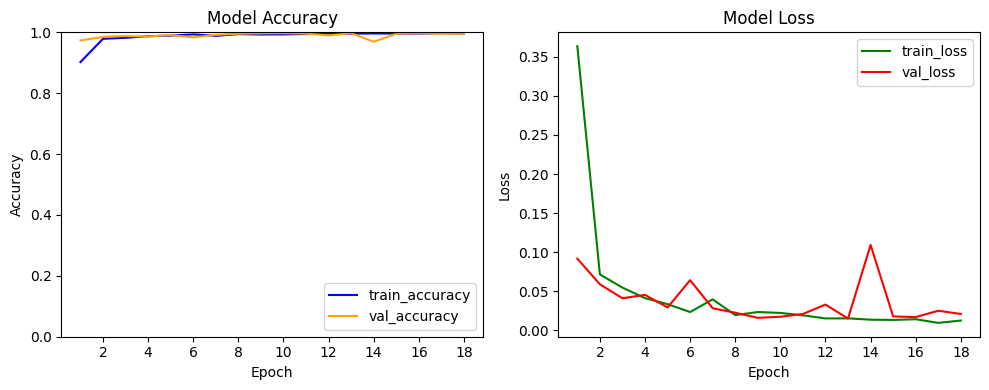

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.001,
Batch Size: 16,
Validation accuracy: 99.73%,
Test Accuracy: 97.91%.

Training model with learning rate = 0.001 and Batch Size = 32
Epoch 1/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.7523 - loss: 1.0101 - val_accuracy: 0.9834 - val_loss: 0.0644
Epoch 2/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9900 - loss: 0.0367 - val_accuracy: 0.9732 - val_loss: 0.0899
Epoch 3/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9910 - loss: 0.0313 - val_accuracy: 0.9935 - val_loss: 0.0232
Epoch 4/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9925 - loss: 0.0250 - val_accuracy: 0.9931 - val_loss: 0.0255
Epoch 5/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9930 - loss: 0.0260 - val_accuracy: 0.9943 - val_loss: 0.0198
Epoch 6/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9945 - loss: 0.0172 - val_accuracy: 0.9921 - val_loss: 0.0242
Epoch 7/50
980/980 ━━━━━━━━━━━━━━━━━

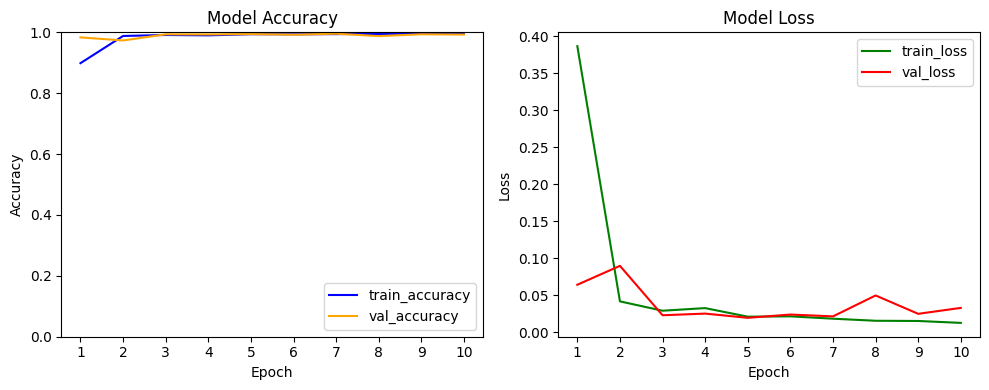

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.43%,
Test Accuracy: 96.21%.

Training model with learning rate = 0.001 and Batch Size = 64
Epoch 1/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7196 - loss: 1.1758 - val_accuracy: 0.7054 - val_loss: 0.9012
Epoch 2/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9898 - loss: 0.0380 - val_accuracy: 0.9861 - val_loss: 0.0502
Epoch 3/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9968 - loss: 0.0138 - val_accuracy: 0.9887 - val_loss: 0.0368
Epoch 4/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9957 - loss: 0.0157 - val_accuracy: 0.9946 - val_loss: 0.0207
Epoch 5/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9974 - loss: 0.0105 - val_accuracy: 0.9921 - val_loss: 0.0270
Epoch 6/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9971 - loss: 0.0112 - val_accuracy: 0.9922 - val_loss: 0.0280
Epoch 7/50
490/490 ━━━━━━━━━━━━━━━━━

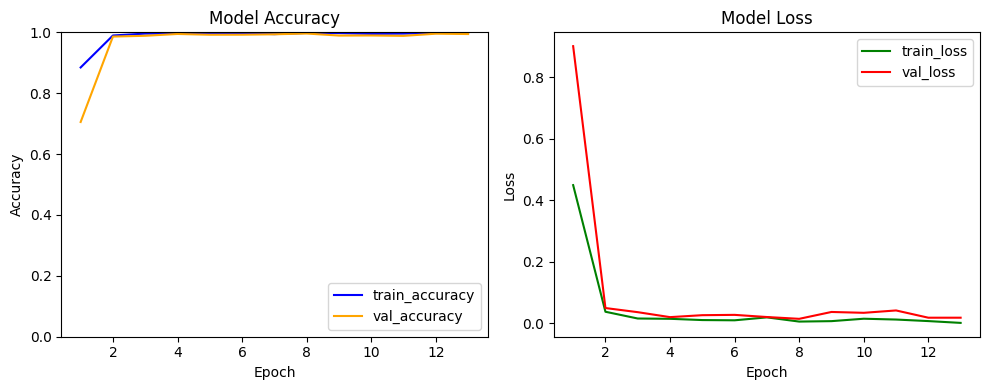

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.001,
Batch Size: 64,
Validation accuracy: 99.60%,
Test Accuracy: 96.97%.

Training model with learning rate = 0.001 and Batch Size = 128
Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.6887 - loss: 1.3109 - val_accuracy: 0.1228 - val_loss: 3.3124
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9904 - loss: 0.0379 - val_accuracy: 0.9134 - val_loss: 0.3237
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9978 - loss: 0.0118 - val_accuracy: 0.9945 - val_loss: 0.0194
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9991 - loss: 0.0053 - val_accuracy: 0.9949 - val_loss: 0.0180
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9989 - loss: 0.0056 - val_accuracy: 0.9874 - val_loss: 0.0465
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9983 - loss: 0.0065 - val_accuracy: 0.9959 - val_loss: 0.0162
Epoch 7/50
245/245 ━━━━━━━━━━━

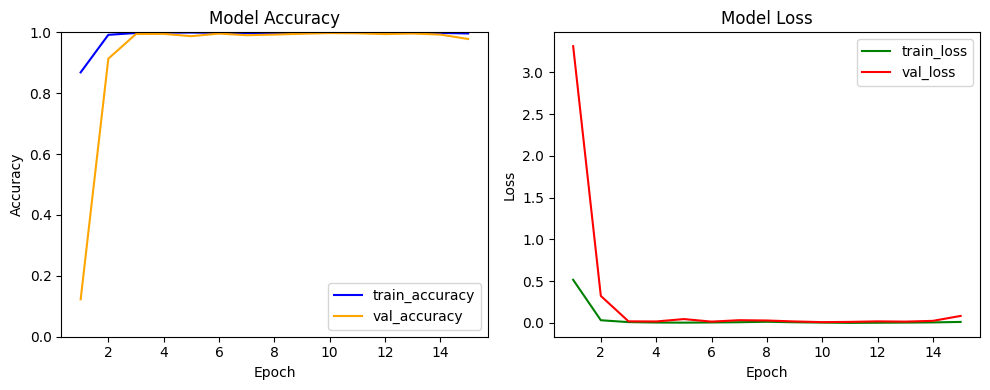

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.76%,
Test Accuracy: 97.22%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

batch_sizes = [16, 32, 64, 128]
lr = 0.001
EPOCHS = 50

for BATCH_SIZE in batch_sizes:

    print(f"\nTraining model with learning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = create_cnn_model((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

##Learning rate 0.0001


Training model with Learning rate = 0.0001 and Batch Size = 16
Epoch 1/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.5578 - loss: 1.8141 - val_accuracy: 0.9718 - val_loss: 0.1149
Epoch 2/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9546 - loss: 0.1691 - val_accuracy: 0.9892 - val_loss: 0.0444
Epoch 3/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9805 - loss: 0.0763 - val_accuracy: 0.9929 - val_loss: 0.0276
Epoch 4/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9900 - loss: 0.0399 - val_accuracy: 0.9932 - val_loss: 0.0243
Epoch 5/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9959 - loss: 0.0206 - val_accuracy: 0.9932 - val_loss: 0.0248
Epoch 6/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9961 - loss: 0.0174 - val_accuracy: 0.9964 - val_loss: 0.0142
Epoch 7/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9965 - loss: 0.0141 - val_accuracy: 0.9971 - val_loss: 0.0118
Epoch 8/50
1960/1960 ━━

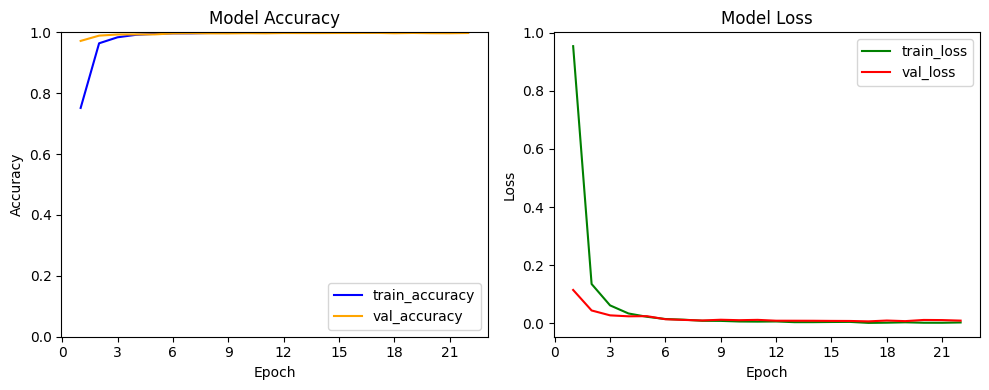

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.0001,
Batch Size: 16,
Validation accuracy: 99.82%,
Test Accuracy: 97.60%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

batch_sizes = [16]
lr = 0.0001
EPOCHS = 50

for BATCH_SIZE in batch_sizes:
    print(f"\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = create_cnn_model((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

##Best models results with more epochs:
Learning rate: 0.001,
Batch Size: 16,
Validation accuracy: 99.73%,
Test Accuracy: **97.91%**.

Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.43%,
Test Accuracy: 96.21%.

Learning rate: 0.001,
Batch Size: 64,
Validation accuracy: 99.60%,
Test Accuracy: 96.97%.

Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.76%,
Test Accuracy: 97.22%.

Learning rate: 0.0001,
Batch Size: 16,
Validation accuracy: 99.82%,
Test Accuracy: **97.60%**.

**Best two models will be trained on oversampled dataset in the next step.**

#Part 5: Synthetic Minority Oversampling Technique (SMOTE)

Applying Synthetic Minority Oversampling Technique (SMOTE) to over-sample the classes which are under-represented. This helps balance the dataset and improve the performance of machine learning models, particularly for imbalanced classification tasks.

In [ ]:
train_images, train_labels = images, labels

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

train_rows=len(train_images)
train_images = train_images.reshape(train_rows,-1)

train_images, train_labels = sm.fit_resample(train_images, train_labels)
train_images = train_images.reshape(-1,32,32,3)

print(f'Total number of train images and labels after applying SMOTE')
print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')

Total number of train images and labels after applying SMOTE
Train images shape: (96750, 32, 32, 3)
Train labels shape: (96750, 43)


##Split dataset into training and validation set
Here, the dataset will be splited into training and validation sets, where 70% of the dataset will be used for training, and the remaining 30% for validation. This keeps a validation set for observing model performance and preventing overfitting while making sure a sufficient training set for model training.

In [ ]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Training data shape: (77400, 32, 32, 3)
Validation data shape: (19350, 32, 32, 3)


##Compile and train the model


Training model with Learning rate = 0.001 and Batch Size = 16
Epoch 1/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.8901 - loss: 0.4364 - val_accuracy: 0.9905 - val_loss: 0.0289
Epoch 2/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9878 - loss: 0.0411 - val_accuracy: 0.9967 - val_loss: 0.0118
Epoch 3/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9934 - loss: 0.0211 - val_accuracy: 0.9959 - val_loss: 0.0199
Epoch 4/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9957 - loss: 0.0151 - val_accuracy: 0.9976 - val_loss: 0.0096
Epoch 5/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9946 - loss: 0.0182 - val_accuracy: 0.9978 - val_loss: 0.0088
Epoch 6/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9964 - loss: 0.0125 - val_accuracy: 0.9986 - val_loss: 0.0060
Epoch 7/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9973 - loss: 0.0096 - val_accuracy: 0.9964 - val_loss: 0.0160
Epoch 8/50
4837/4837

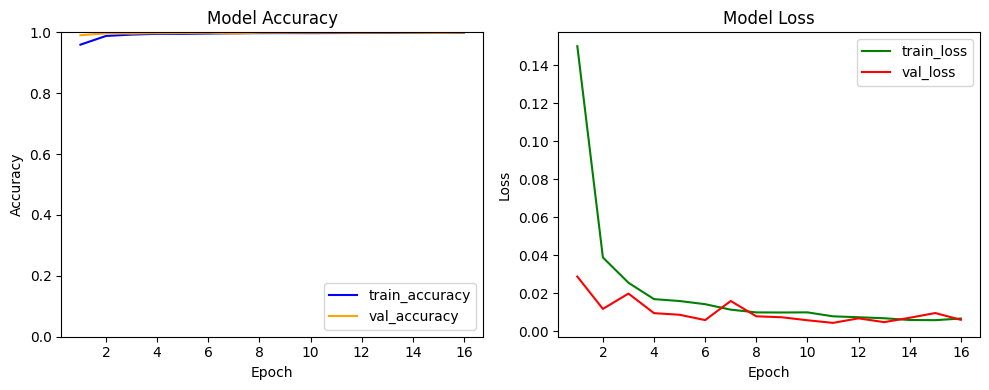

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.001,
Batch Size: 16,
Validation accuracy: 99.93%,
Test Accuracy: 97.98%.

Training model with Learning rate = 0.0001 and Batch Size = 16
Epoch 1/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.7480 - loss: 1.0263 - val_accuracy: 0.9935 - val_loss: 0.0247
Epoch 2/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9906 - loss: 0.0370 - val_accuracy: 0.9974 - val_loss: 0.0095
Epoch 3/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9963 - loss: 0.0152 - val_accuracy: 0.9984 - val_loss: 0.0057
Epoch 4/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9980 - loss: 0.0074 - val_accuracy: 0.9984 - val_loss: 0.0060
Epoch 5/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9988 - loss: 0.0054 - val_accuracy: 0.9984 - val_loss: 0.0060
Epoch 6/50
4837/4837 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9990 - loss: 0.0037 - val_accuracy: 0.9984 - val_loss: 0.0057
Epoch 7/50
4837/483

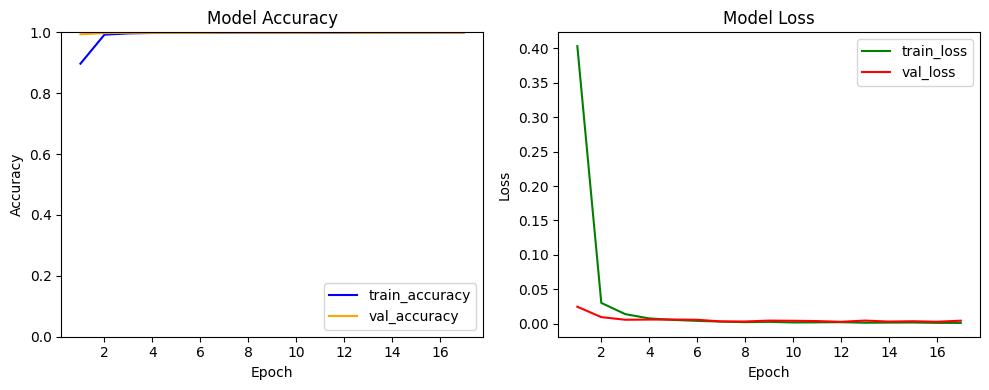

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Learning rate: 0.0001,
Batch Size: 16,
Validation accuracy: 99.95%,
Test Accuracy: 97.88%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Best model parameters
BATCH_SIZE = 16
learning_rate = [0.001, 0.0001]

# Set epochs
EPOCHS = 50
for lr in learning_rate:
    print(f"\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = create_cnn_model((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

##Best models results on oversampled dataset

Learning rate: 0.001,
Batch Size: 16,
Validation accuracy: 99.93%,
Test Accuracy: **97.98%**.

Learning rate: 0.0001,
Batch Size: 16,
Validation accuracy: 99.95%,
Test Accuracy: 97.88%.

#Conclusion
**Best model parameters:** <br>
Learning rate: 0.001<br>
Batch size: 16<br>
**Best Accuracy:** **97.98%**.

